<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [232]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [233]:
# Load the data
house = pd.read_csv('./housing.csv')

In [234]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [235]:
house.shape

(1460, 81)

In [236]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [237]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Removing house that isn't residential

In [238]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [239]:
house_R=house[house['MSZoning'].str.contains('R')].copy()
house_R.shape

#before=(1460, 81)

(1385, 81)

#### Checking Missing data

In [240]:
totalMissing=house_R.isnull().sum().sort_values(ascending=False)
percentages=((house_R.isnull().sum()/house_R.isnull().count())*100).sort_values(ascending=False)

missing_data=pd.concat([totalMissing,percentages],axis=1,keys=['Total','Percentages'])
missing_data[missing_data['Total']>0]

,Total,Percentages
PoolQC,1378,99.494585
MiscFeature,1333,96.245487
Alley,1320,95.306859
Fence,1108,80.000000
FireplaceQu,641,46.281588
LotFrontage,251,18.122744
GarageCond,79,5.703971
GarageType,79,5.703971
GarageYrBlt,79,5.703971
GarageFinish,79,5.703971


#### Dropping columns with > 80% missing values

In [241]:
house_R.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)
house_R.shape
#previous shape (1385, 81)

(1385, 77)

#### Fill missing values 

In [242]:
#fyi didn't use it in the end

#identify variables with mostly the same values so as to eliminate them 
#in this case, i will take those columns with less than 5 no of unique values
columns_uni = []
for column in list(house_R.columns[house_R.nunique()<5]):
    columns_uni.append(column)
    
for c in columns_uni:
    print(house_R[c].value_counts(), '\n')
    
# I intend to remove columns with too many similar variables as it will not help to 
#explain the difference in price
# The columns identified are Street, LandContour, BsmtCond, CentralAir, KitchenAbvGr, PavedDrive. 

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64 

Pave    1381
Grvl       4
Name: Street, dtype: int64 

Reg    864
IR1    473
IR2     38
IR3     10
Name: LotShape, dtype: int64 

Lvl    1240
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64 

AllPub    1384
NoSeWa       1
Name: Utilities, dtype: int64 

Gtl    1310
Mod      62
Sev      13
Name: LandSlope, dtype: int64 

None       816
BrkFace    432
Stone      117
BrkCmn      15
Name: MasVnrType, dtype: int64 

TA    893
Gd    432
Ex     49
Fa     11
Name: ExterQual, dtype: int64 

TA    639
Gd    561
Ex    113
Fa     35
Name: BsmtQual, dtype: int64 

TA    1242
Gd      61
Fa      43
Po       2
Name: BsmtCond, dtype: int64 

No    897
Av    210
Gd    134
Mn    106
Name: BsmtExposure, dtype: int64 

Y    1296
N      89
Name: CentralAir, dtype: int64 

0    803
1    566
2     15
3      1
Name: BsmtFullBath, dtype: int64 

0    1304
1      79
2       2
Name: BsmtHalfBath, dtype: int64 

2    706
1    640
3

In [243]:
#identify columns that are category type
house_R.select_dtypes(exclude=['int64', 'float64']).head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [244]:
house_R.select_dtypes(exclude=['int64', 'float64']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [245]:
#note: I have used house data instead of house for simpicity as I need not concat the target and variables
house_cat= house_R[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']]

#convert category columns to dummy 
house_cat_dummy = pd.get_dummies(house_cat)
print(house_cat_dummy.shape)

#add the target variable (impt to add it only after get_dummies)
house_cat_dummy['SalePrice'] = house['SalePrice']
print(house_cat_dummy.shape)

#oh my, i have 200+ columns!

(1385, 237)
(1385, 238)


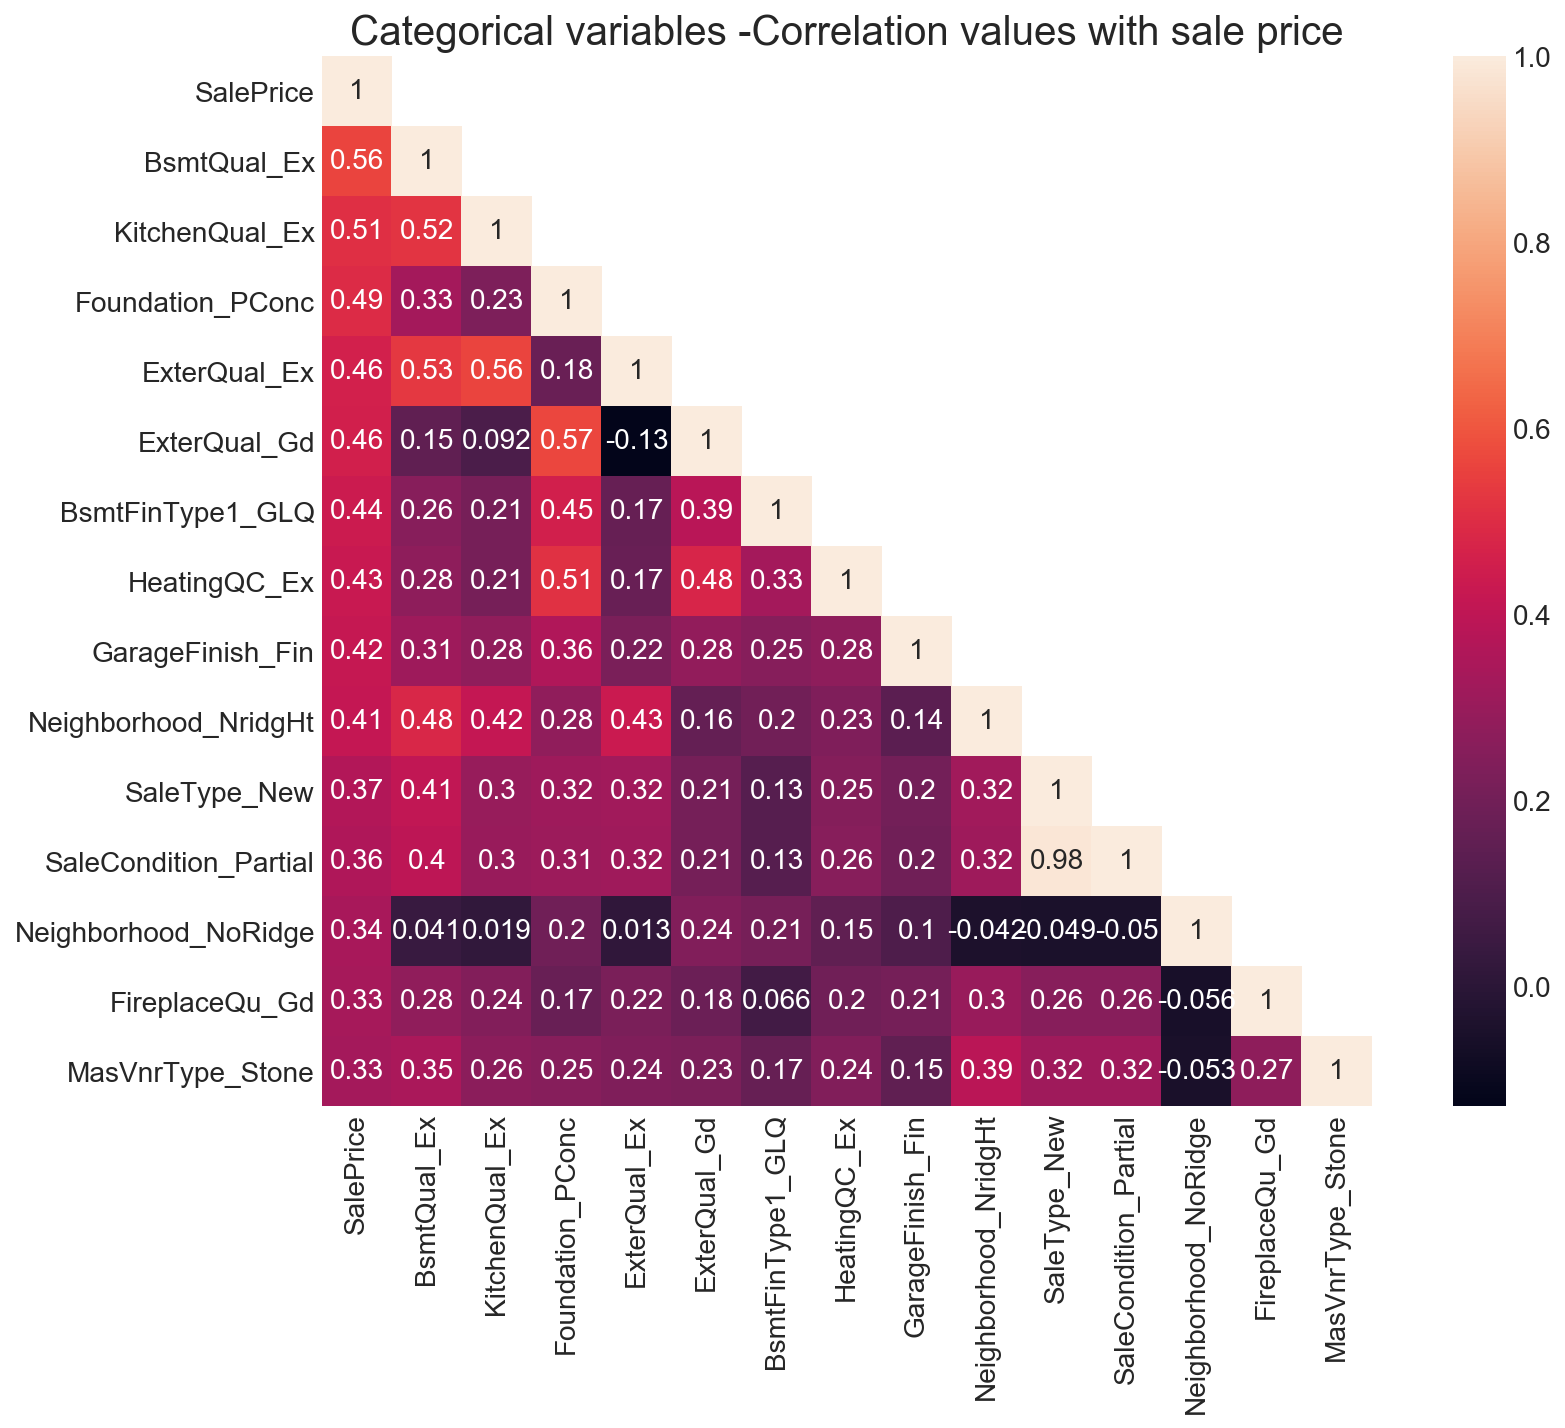

In [246]:
#Select the top 15 category variables that are correlated to sale price 
#the correlation values ranges between 0.3 to 0.5 which is generally acceptable 
#pls look at the first column values of the heat map 
#interestingly, notice that this dataset does not have many - corr values 

fig, ax = plt.subplots(figsize=(13,9))
corrmap=house_cat_dummy.corr()

cols=corrmap.nlargest(15,'SalePrice')['SalePrice'].index
cm=np.corrcoef(house_cat_dummy[cols].values.T)
mask=np.array(cm)
mask[np.tril_indices_from(mask)]=False
ax = sns.heatmap(cm,cbar=True,mask=mask,annot=True,square=True,yticklabels=cols.values, xticklabels=cols.values)
plt.title('Categorical variables -Correlation values with sale price')
plt.show()


#great!! ^.^ now we can pick filter and pick these category variables that are more impt! 

In [247]:
house_R.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [248]:
#from heatmap, we have identified top correlated categorical columns
#rmb to remove the additional chars after the column names (created by get_dummies)
missing_cat = ['BsmtQual', 'KitchenQual', 'Foundation',
       'ExterQual', 'ExterQual', 'BsmtFinType1', 'HeatingQC',
       'GarageFinish', 'Neighborhood', 'SaleType',
       'SaleCondition', 'Neighborhood', 'FireplaceQu',
       'MasVnrType']

house_R[missing_cat]=house_R[missing_cat].fillna('None')

In [249]:
house_R.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      251
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         5
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
                ... 
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageType        79
GarageYrBlt       79
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual        79
GarageCond   

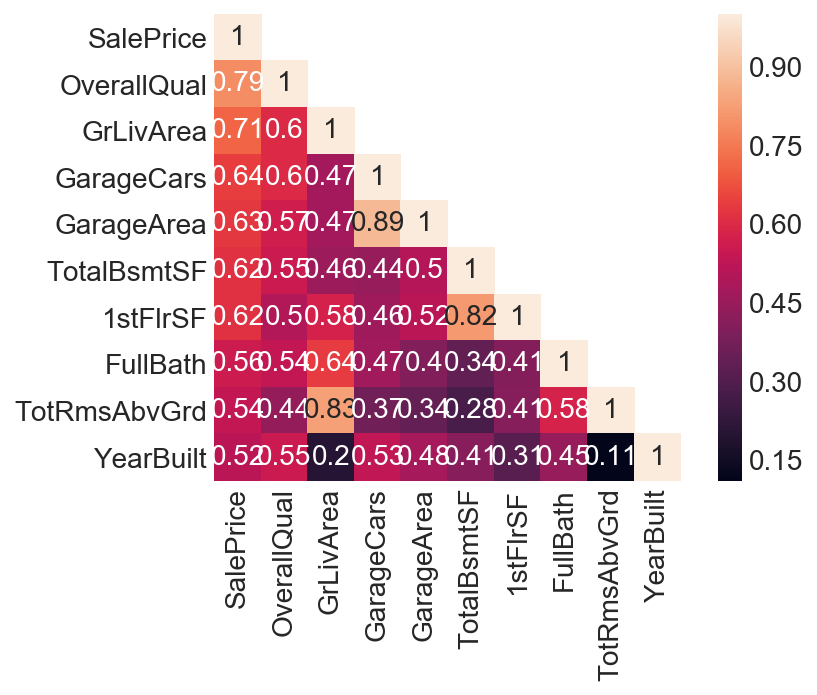

In [250]:
#Get the top 10 correlated numerical columns
corrmat=house_R.corr()
cols=corrmat.nlargest(10,'SalePrice')['SalePrice'].index
cm=np.corrcoef(house_R[cols].values.T)
mask=np.array(cm)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(cm,cbar=True,mask=mask,annot=True,square=True,yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [251]:
#the top numerical AND categorical columns correlated with sale price are...
topcol = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
        'BsmtQual', 'KitchenQual', 'Foundation',
       'ExterQual', 'ExterQual', 'BsmtFinType1', 'HeatingQC',
       'GarageFinish', 'Neighborhood', 'SaleType',
       'SaleCondition', 'Neighborhood', 'FireplaceQu',
       'MasVnrType']


#manually identified the the fixed variables (consist of numerical/ categorical) from topcol variables
#filtered those that were repeated/ highly correlated (e.g. garage area and carage cars)
#my definition of fixed features are those that are permanent and would need extensive overhaul if renovation is needed. 
top_fixed = ['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt',
        'BsmtQual', 'Foundation','Neighborhood', 'MasVnrType']

#differientiate those that are category vs numerical
house[top_fixed].select_dtypes(include=['int64', 'float64']).columns


Index(['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt'], dtype='object')

In [252]:
top_fixed_cat = ['BsmtQual', 'Foundation', 'Neighborhood', 'MasVnrType']

top_fixed_num = ['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']



In [253]:
house_R.shape

(1385, 77)

In [254]:
#create a df with numerical columns first 
#rmb to add target variable(sale price) and Yearsold as well

#? to Marcus/Jin: why wont it work if i put 
#house_final = house_R[top_fixed_num]

house_final = house_R[['SalePrice','GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YrSold']]
print(house_final.shape)

#create a df with cat columns 
house_dummy = house_R[['BsmtQual', 'Foundation', 'Neighborhood', 'MasVnrType']]
house_dummy = pd.get_dummies(house_dummy)
print(house_dummy.shape)

#concat two df along the y axis 
result = pd.concat([house_final, house_dummy], axis=1, sort=False)
print(result.shape)
result.head()

#Now I have 45 columns in numerical valuesresu!!!! 

(1385, 6)
(1385, 40)
(1385, 46)


,SalePrice,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,YrSold,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,...,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,208500,548,856,856,2003,2008,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,181500,460,1262,1262,1976,2007,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,223500,608,920,920,2001,2008,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,140000,642,756,961,1915,2006,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,250000,836,1145,1145,2000,2008,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


#### Analyzing target variable : SalePrice

C:\Users\Clare\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


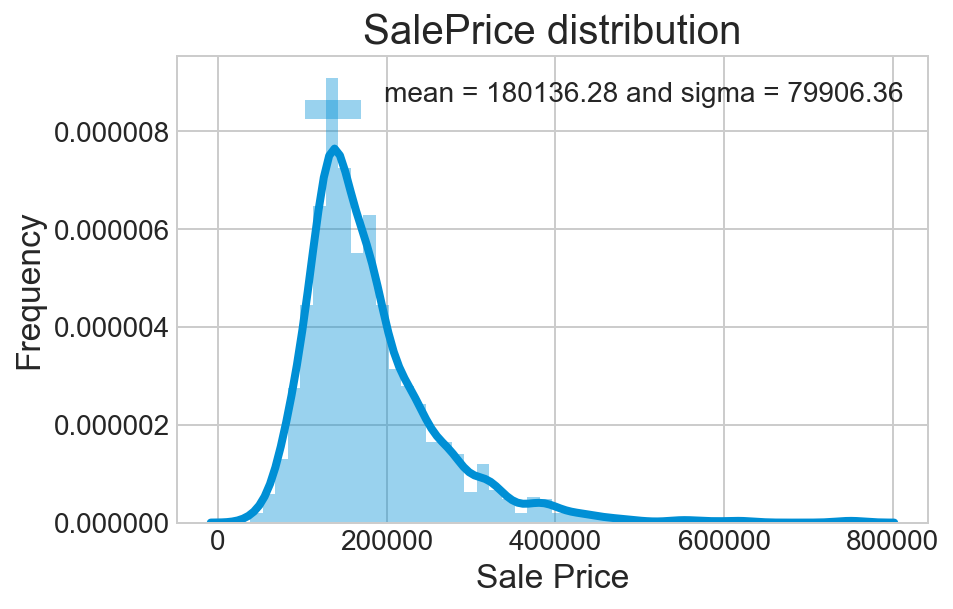

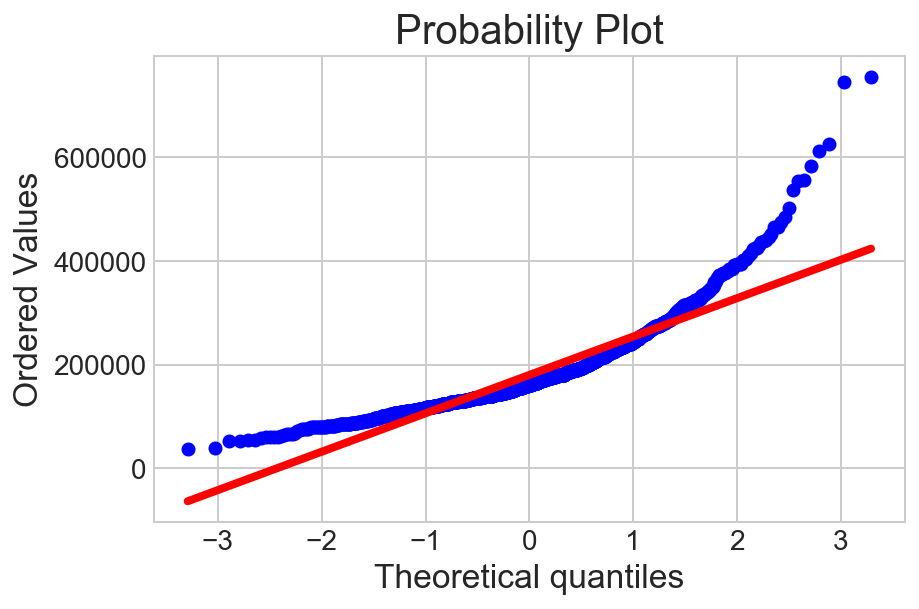

In [255]:
from scipy import stats
sns.distplot(result['SalePrice'])

plt.legend(['mean = {:.2f} and sigma = {:.2f}\n'.format(result['SalePrice'].mean(), result['SalePrice'].std())],
          loc='best')
plt.ylabel('Frequency')
plt.xlabel('Sale Price')
plt.title('SalePrice distribution')

result['SalePrice'].skew()

# Plot Q-Q plot 
fig=plt.figure()
stats.probplot(result['SalePrice'],plot=plt)
plt.show()

We can clearly see that the 'SalePrice' distribution is right-skewed

C:\Users\Clare\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


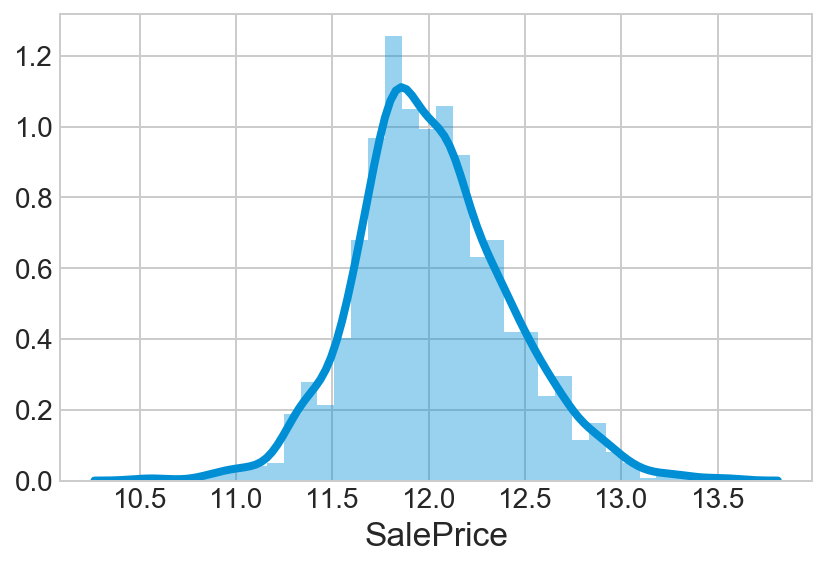

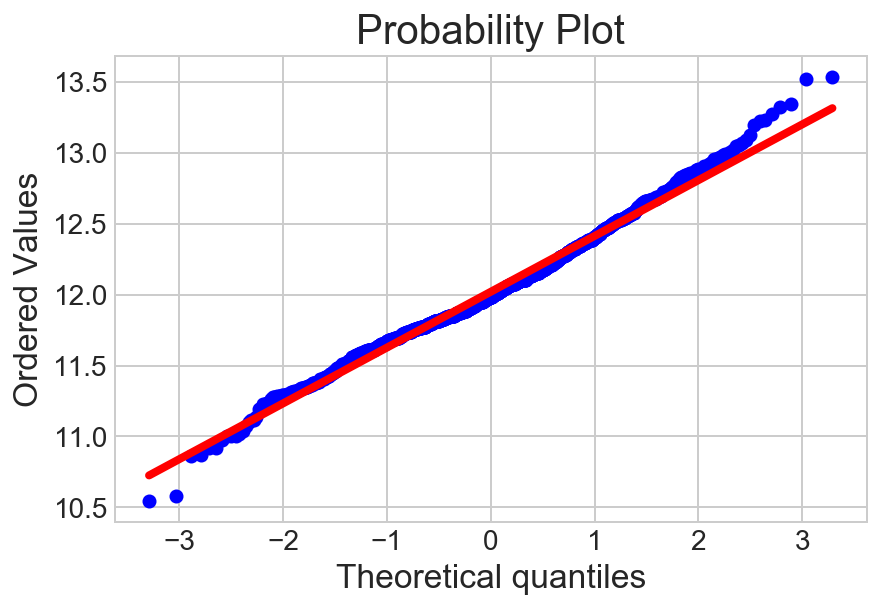

In [256]:
### Transforming Sale Price to normalise it 
result['SalePrice']=np.log(result['SalePrice'])
sns.distplot(result['SalePrice']);
fig=plt.figure()
res=stats.probplot(result['SalePrice'],plot=plt)

#### Train test split

In [257]:
result.columns

Index(['SalePrice', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt',
       'YrSold', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None',
       'BsmtQual_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkF

In [258]:
#is this correct? Or should I split the test as (result.YrSold == 2010)??
# I sort of have two test sets now

#create training data 
house_pre2010 = result[result.YrSold < 2010]

#convert to arrayfor y thus use .value 
y = house_pre2010.SalePrice.values

# selection independent variables
predictors = ['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt',
       'YrSold', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None',
       'BsmtQual_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone']

# create train and test sets (50/50)
X_train, X_test, y_train, y_test = train_test_split(house_pre2010[predictors], 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=8)

C:\Users\Clare\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [259]:
#create post 2010 test data 
house_2010 = result[result.YrSold == 2010]

y_2010 = house_2010.SalePrice.values
X_2010 = house_2010[predictors]


#### Standardize the predictors

In [260]:
# Standardize the predictors
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)
print(Xs_train.shape)

(976, 45)


C:\Users\Clare\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Clare\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


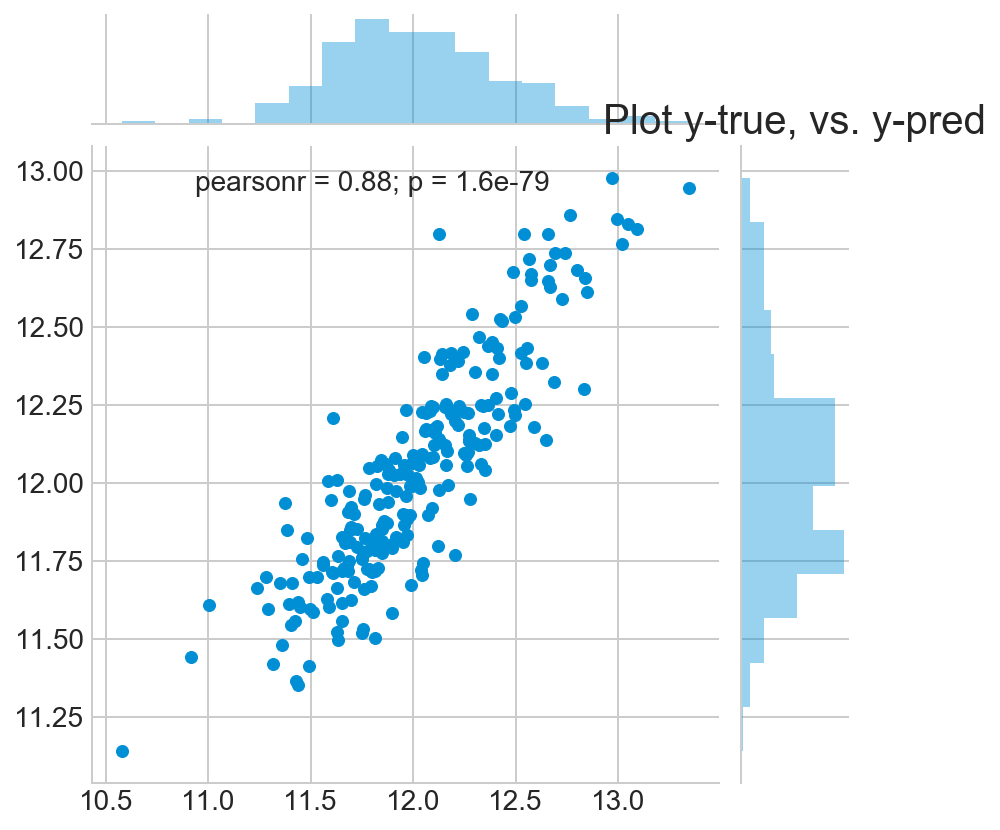

In [261]:
# set model
lr = LinearRegression()
# fit model using train data
lr.fit(X_train, y_train)
# score the fit model using the test data.
lr.score(X_test, y_test)

# plot y-true, vs. y-pred
yhat = lr.predict(X_test)
ax = sns.jointplot(y_test, yhat)
plt.title('Plot y-true, vs. y-pred')
plt.show()

#### Try stats model to exclude not significant features

MSE: 0.04103049767635017


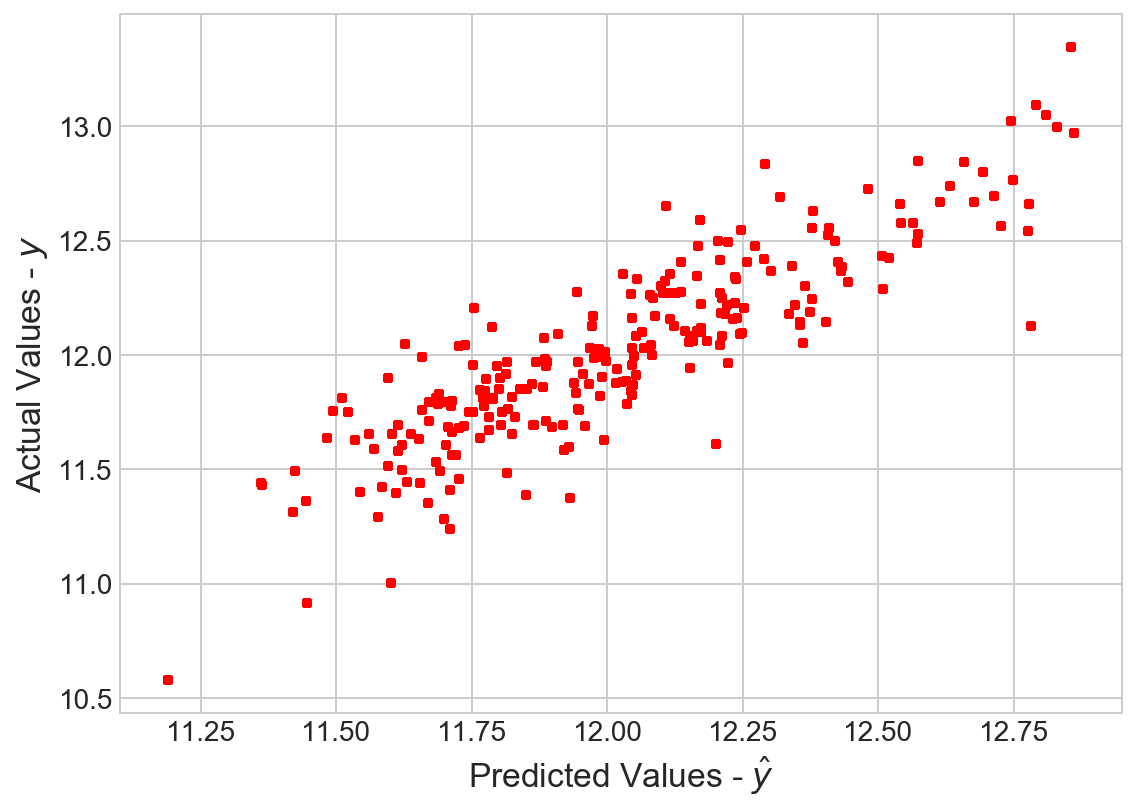

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     67.37
Date:                Fri, 12 Oct 2018   Prob (F-statistic):          1.13e-247
Time:                        02:23:13   Log-Likelihood:                 207.93
No. Observations:                 976   AIC:                            -331.9
Df Residuals:                     934   BIC:                            -126.8
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0923      0.009     10.405      0.000       0.075       0.110
x2            -0.0406      0.016     -2.564      0.011      -0.072      -0.010
x3             0.1253      0.015      8.630      0.000       0.097       0.154
x4             0.0069      0.017      0.405      0.685      -0.026       0.040
x5            -0.0107      0.007     -1.630      0.103      -0.024       0.002
x6             0.0592      0.008      7.452      0.000       0.044       0.075
x7            -0.0333      0.007     -4.919      0.000      -0.047      -0.020
x8             0.0253      0.006      4.388      0.000       0.014       0.037
x9            -0.0571      0.012     -4.791      0.000      -0.081      -0.034
x10           -0.0305      0.006     -4.742      0.000      -0.043      -0.018
x11           -0.0003      0.008     -0.033      0.974      -0.015       0.015
x12           -0.0094      0.005     -1.708      0.088      -0.020       0.001
x13            0.0104      0.006      1.665      0.096      -0.002       0.023
x14           -0.0070      0.011     -0.642      0.521      -0.028       0.014
x15            0.0066      0.006      1.010      0.313      -0.006       0.019
x16            0.0041      0.007      0.633      0.527      -0.009       0.017
x17           -0.0083      0.007     -1.242      0.214      -0.021       0.005
x18           -0.0035      0.006     -0.535      0.593      -0.016       0.009
x19           -0.0220      0.007     -3.258      0.001      -0.035      -0.009
x20           -0.0156      0.007     -2.141      0.033      -0.030      -0.001
x21            0.0275      0.006      4.289      0.000       0.015       0.040
x22            0.0081      0.007      1.116      0.265      -0.006       0.022
x23            0.0360      0.007      5.369      0.000       0.023       0.049
x24           -0.0357      0.006     -5.631      0.000      -0.048      -0.023
x25            0.0285      0.007      3.906      0.000       0.014       0.043
x26           -0.0278      0.007     -4.056      0.000      -0.041      -0.014
x27           -0.0385      0.006     -5.925      0.000      -0.051      -0.026
x28           -0.0249      0.006     -3.928      0.000      -0.037      -0.012
x29           -0.0227      0.007     -3.419      0.001      -0.036      -0.010
x30           -0.0016      0.006     -0.245      0.806      -0.014       0.011
x31            0.0108      0.007      1.650      0.099      -0.002       0.024
x32            0.0569      0.007      8.396      0.000       0.044       0.070
x33            0.0439      0.008      5.528      0.000       0.028       0.059
x34           -0.0329      0.008     -3.886      0.000      -0.050      -0.016
x35           -0.0016      0.007     -0.226      0.821      -0.015       0.012
x36           -0.0182      0.006     -2.834      0.005      -0.031      -0.006
x3

In [262]:
import statsmodels.api as sm
from sklearn import metrics
X_train_OLS=np.concatenate([Xs_train, np.ones((X_train.shape[0], 1))], axis=1)
X_test_OLS=np.concatenate([Xs_test, np.ones((X_test.shape[0], 1))], axis=1)

model=sm.OLS(y_train,X_train_OLS)
model=model.fit()
predictions_OLS=model.predict(X_test_OLS)

# Plot the model
print("MSE:", metrics.mean_squared_error(y_test, predictions_OLS))

plt.figure(figsize=(8,6))
plt.scatter(predictions_OLS, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

model.summary()

# Results
#R square > 0.7, the model is reasonably good





#### Removing 'YrSold', 'YearBuilt'

In [263]:
# selection independent variables
predictors = ['GarageArea', 'TotalBsmtSF', '1stFlrSF', 
        'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None',
       'BsmtQual_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone']

# create train and test sets (50/50)
X_train, X_test, y_train, y_test = train_test_split(house_pre2010[predictors], 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=8)
                            


# Standardize the predictors
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

C:\Users\Clare\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Building linear regression model

Average CV score -5.695827348115245e+26
Score: -1.1381084031094219e+23
RMSE: 139844594425.9785
[ 9.27173058e-02 -4.03622367e-02  1.25080117e-01  4.59212529e+11
  2.47044837e+11  7.97712736e+11  2.52225801e+11  8.12322705e+11
 -1.70865780e+11 -2.75808374e+11 -2.73044555e+11 -7.03195026e+10
 -2.50423256e+10 -2.50423256e+10 -7.33006763e+10 -2.89146299e+10
 -7.86557516e+10 -1.28268760e+11 -9.27757545e+10 -1.98119347e+11
 -1.22111571e+11 -1.70300604e+11 -1.49940290e+11 -8.83397022e+10
 -6.74967965e+10 -1.29754146e+11 -2.33701010e+11 -4.08494572e+10
 -1.46179174e+11 -9.69914674e+10 -1.42291552e+11 -1.73383846e+11
 -8.11930339e+10 -1.36892592e+11 -1.28268760e+11 -8.36482628e+10
 -8.11930339e+10 -1.04866832e+11 -6.11163844e+10 -3.54300804e+09
 -1.43122774e+10 -1.51817506e+10 -8.47786148e+09]
12.023001765584052


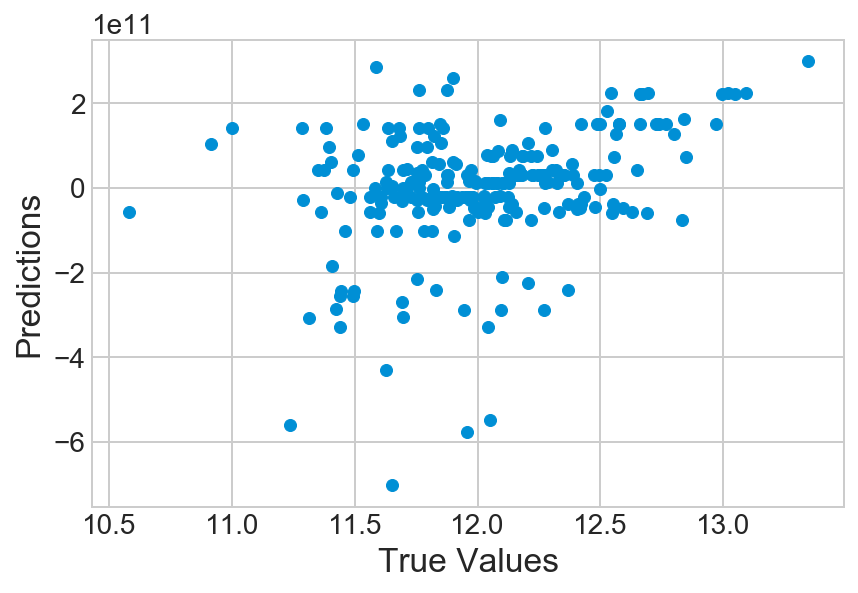

In [264]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lm = linear_model.LinearRegression(normalize=True)

model = lm.fit(Xs_train, y_train)
predictions = lm.predict(Xs_test)

lm_scores = cross_val_score(model, Xs_test, y_test, cv=10)
print("Average CV score",np.mean(lm_scores))

print("Score:", model.score(Xs_test, y_test))

# calculate RMSE
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# examine the coefficients
print(lm.coef_)
print(lm.intercept_)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

This is a rather bad model
#Any suggestions for improvement? I shall proceed with other models first. 

#### Using Lasso Regression

In [265]:
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.001, normalize=True)
lassoreg.fit(Xs_train, y_train)
y_pred = lassoreg.predict(Xs_test)

print("Score: ",lassoreg.score(Xs_test, y_test))
print("RMSE : ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Score:  0.6820949339208271
RMSE :  0.23372361407104209


#### Finding optimal value with LassoCV

In [266]:
from sklearn.linear_model import LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)
y_pred =optimal_lasso.predict(Xs_test)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0036828577001812644


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [267]:
print("Best alpha: ",optimal_lasso.alpha_)
print("Score :", optimal_lasso.score(Xs_test, y_test))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Best alpha:  0.0036828577001812644
Score : 0.7595778042204231
RMSE:  0.2032549581252244


In [268]:
# examine the coefficients
lasso_coefs = pd.DataFrame({'variable':['GarageArea', 'TotalBsmtSF', '1stFlrSF', 
        'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_None',
       'BsmtQual_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone'],
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

,variable,coef,abs_coef
2,1stFlrSF,0.097097,0.097097
0,GarageArea,0.097066,0.097066
3,BsmtQual_Ex,0.075755,0.075755
5,BsmtQual_Gd,0.062148,0.062148
29,Neighborhood_NoRidge,0.049317,0.049317


#### Ridge Regression Model

In [269]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0, normalize=True)
ridgereg.fit(Xs_train, y_train)
y_pred = ridgereg.predict(Xs_test)
print("Score:", ridgereg.score(Xs_test, y_test))
print("RMSE alpha=0: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Score: 0.7630303462555433
RMSE alpha=0:  0.20179027666202692


In [270]:
from sklearn.linear_model import RidgeCV
alpha_range = [0.001, 0.1, 1, 10, 25, 50, 100, 200]
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error')
ridgeregcv.fit(Xs_train, y_train)
# predict method uses the best alpha value
y_pred = ridgeregcv.predict(Xs_test)

print("Best alpha: ", ridgeregcv.alpha_)
print("Best intercept: ", ridgeregcv.intercept_)
print("Score:", ridgeregcv.score(Xs_test, y_test))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Best alpha:  0.1
Best intercept:  12.022982432048874
Score: 0.7591689776482945
RMSE:  0.2034276974438956


### comparison of ridge, lasso regression and linear regression
Linear Regression, Score:  BAD <br>
Lasso Regression,Score : 0.7595 <br>
Ridge Regression,Score : 0.759 <br><br>
    
Lasso Regression gave a better model
    

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [271]:
house_R.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1385.000000,1385.000000,1134.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1380.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,732.506137,55.328520,70.583774,10706.158845,6.063538,5.607942,1970.048375,1984.121300,102.768841,450.666426,...,96.589170,43.865704,22.547292,3.594224,15.662094,2.908303,45.400722,6.314079,2007.810830,180136.283032
std,422.536319,40.883271,24.251032,10185.732173,1.373366,1.125799,29.831024,20.554236,174.373232,459.231291,...,126.994291,63.585425,62.067644,30.090182,56.883779,41.246294,509.097441,2.695583,1.326813,79906.363281
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,365.000000,20.000000,60.000000,7711.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129000.000000
50%,734.000000,50.000000,70.000000,9591.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,387.000000,...,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,1101.000000,70.000000,80.000000,11751.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,719.000000,...,169.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212900.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [335]:
### Transforming Sale Price
house_R['SalePrice']=np.log(result['SalePrice'])

house_R['MasVnrArea']=house_R['MasVnrArea'].fillna(0)

house_R['LotFrontage']=house_R.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

missing_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2', 
      'BsmtExposure', 'BsmtCond', 'BsmtCond', 'BsmtQual'
     ,'MasVnrType','Electrical','FireplaceQu']

house_R[missing_cat]=house_R[missing_cat].fillna('None')

house_R['GarageYrBlt'].fillna(house_R['YearBuilt'], inplace=True)


In [336]:
#### Converting categorical to numerical variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in ['Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 
                       'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional',  
                       'GarageFinish', 'GarageQual', 'GarageCond','SaleCondition']:
    house_R[i] = le.fit_transform(house_R[i])

print(house_R.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig    ...     EnclosedPorch 3SsnPorch  ScreenPorch  \
0    AllPub    Inside    ...                 0         0            0   
1    AllPub       FR2    ...                 0         0            0   
2    AllPub    Inside    ...                 0         0            0   
3    AllPub    Corner    ...               272         0            0   
4    AllPub       FR2    ...                 0         0            0   

   PoolArea MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0      

In [337]:
house_pre2010.describe()


,Id,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
count,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,...,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,736.054873,55.266175,70.461097,10740.628174,2.027846,2.011466,5.074529,4.599509,1970.022932,1984.049140,...,45.180180,22.199836,3.764128,15.830467,3.298935,40.442260,6.583129,2007.516790,3.764947,12.022181
std,418.689234,40.459841,22.580102,10588.302974,0.875464,0.280280,1.380252,1.120290,30.100288,20.589331,...,65.364516,62.160153,31.051413,57.592776,43.916518,522.821915,2.708338,1.125307,1.092275,0.394412
min,1.000000,20.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,10.542706
25%,377.000000,20.000000,60.000000,7681.000000,2.000000,2.000000,4.000000,4.000000,1952.000000,1966.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,4.000000,11.771436
50%,736.000000,50.000000,70.000000,9591.000000,2.000000,2.000000,5.000000,4.000000,1972.000000,1992.000000,...,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2007.000000,4.000000,11.989160
75%,1102.000000,70.000000,80.000000,11839.000000,2.000000,2.000000,6.000000,5.000000,1999.000000,2003.000000,...,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,4.000000,12.269047
max,1460.000000,190.000000,313.000000,215245.000000,8.000000,7.000000,9.000000,8.000000,2009.000000,2009.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2009.000000,5.000000,13.534473


In [339]:
import patsy

house_pre2010 = house_R[house_R.YrSold < 2010]
house_2010 = house_R[house_R.YrSold == 2010]

f='SalePrice ~'+' + '.join(['Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 
                       'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional',  
                       'GarageFinish', 'GarageQual', 'GarageCond','SaleCondition'])+' -1'
y_train,X_train=patsy.dmatrices(f,data=house_pre2010,return_type='dataframe')
y_train=y_train.values.ravel()
X_train.shape

(1221, 27)

In [340]:
f='SalePrice ~'+' + '.join(['Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 
                       'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional',  
                       'GarageFinish', 'GarageQual', 'GarageCond','SaleCondition'])+' -1'
y_test,X_test=patsy.dmatrices(f,data=house_2010,return_type='dataframe')
y_test=y_test.values.ravel()
X_test.shape
y_test.shape

(164,)

#### Try stats model to exclude not significant features

MSE: 0.00026439980829675533


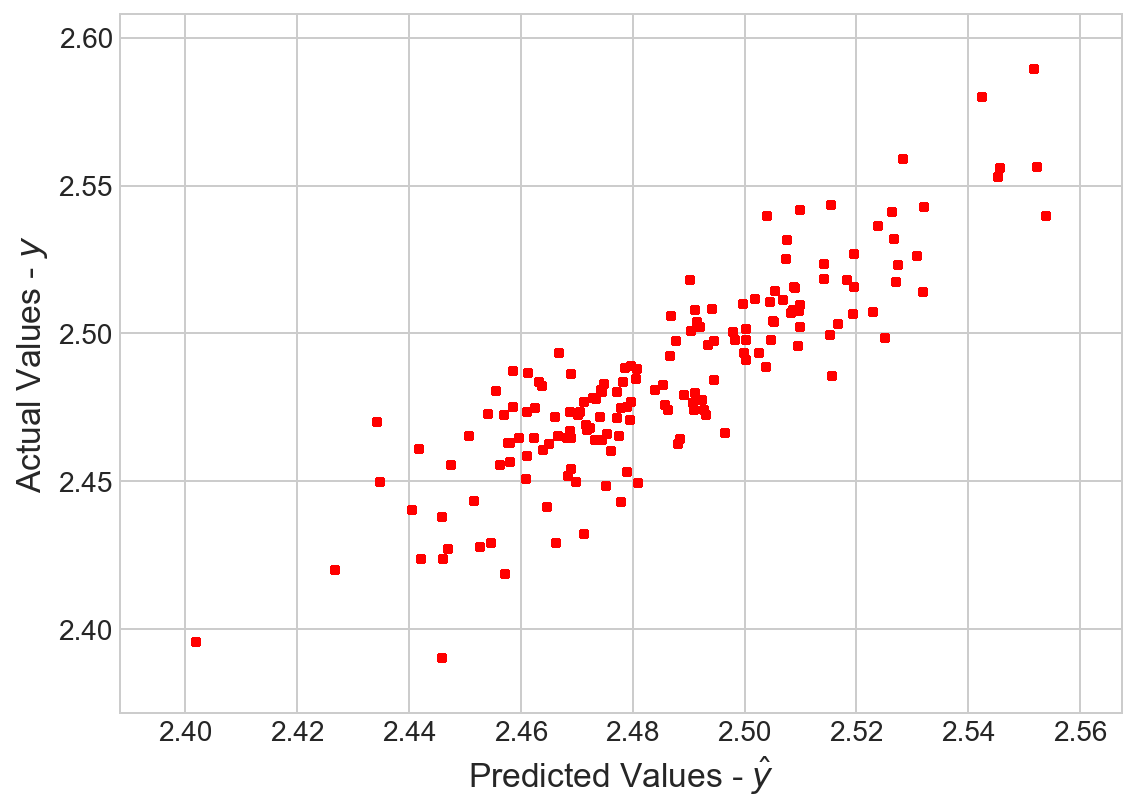

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     127.4
Date:                Fri, 12 Oct 2018   Prob (F-statistic):               0.00
Time:                        03:02:08   Log-Likelihood:                 3272.0
No. Observations:                1221   AIC:                            -6488.
Df Residuals:                    1193   BIC:                            -6345.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.001      1.361      0.174      -0.000       0.002
x2            -0.0019      0.002     -1.109      0.268      -0.005       0.001
x3             0.0133      0.001     23.804      0.000       0.012       0.014
x4             0.0015      0.000      3.142      0.002       0.001       0.002
x5             0.0016      0.001      2.690      0.007       0.000       0.003
x6             0.0033      0.001      4.209      0.000       0.002       0.005
x7            -0.0007      0.000     -2.190      0.029      -0.001    -6.9e-05
x8             0.0005      0.000      1.947      0.052   -4.15e-06       0.001
x9            -0.0012      0.001     -1.508      0.132      -0.003       0.000
x10           -0.0013      0.001     -1.226      0.220      -0.003       0.001
x11            0.0013      0.001      1.903      0.057   -4.11e-05       0.003
x12           -0.0028      0.001     -5.233      0.000      -0.004      -0.002
x13            0.0003      0.001      0.564      0.573      -0.001       0.001
x14           -0.0017      0.000     -6.340      0.000      -0.002      -0.001
x15           -0.0012      0.000     -2.742      0.006      -0.002      -0.000
x16         6.041e-06   2.84e-06      2.123      0.034    4.59e-07    1.16e-05
x17           -0.0006      0.002     -0.352      0.725      -0.004       0.003
x18           -0.0011      0.000     -3.255      0.001      -0.002      -0.000
x19            0.0094      0.002      3.912      0.000       0.005       0.014
x20            0.0009      0.000      2.325      0.020       0.000       0.002
x21            0.0005      0.000      1.505      0.133      -0.000       0.001
x22           -0.0032      0.001     -4.019      0.000      -0.005      -0.002
x23            0.0004      0.000      0.814      0.416      -0.001       0.001
x24           -0.0012      0.000     -2.485      0.013      -0.002      -0.000
x25            0.0019      0.001      2.885      0.004       0.001       0.003
x26            0.0025      0.001      3.246      0.001       0.001       0.004
x27            0.0015      0.000      3.221      0.001       0.001       0.002
const          2.3963      0.009    269.651      0.000       2.379       2.414
==============================================================================
Omnibus:                       36.460   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.183
Skew:                          -0.165   Prob(JB):                     7.79e-17
Kurtosis:                       4.162   Cond. No.                     7.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+03. This might i

In [341]:
import statsmodels.api as sm
from sklearn import metrics
X_train_OLS=np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
X_test_OLS=np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)

model=sm.OLS(y_train,X_train_OLS)
model=model.fit()
predictions_OLS=model.predict(X_test_OLS)

# Plot the model
print("MSE:", metrics.mean_squared_error(y_test, predictions_OLS))

plt.figure(figsize=(8,6))
plt.scatter(predictions_OLS, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

model.summary()

#### Exclude those features p values greater than 0.05

In [342]:
f='SalePrice ~'+' + '.join(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                       'BsmtQual',  
                       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', 
                       'CentralAir',  'KitchenQual',   
                       'GarageFinish', 'GarageQual', 'GarageCond','SaleCondition'])+' -1'
y_train,X_train=patsy.dmatrices(f,data=house_pre2010,return_type='dataframe')
y_train=y_train.values.ravel()
X_train.shape
f='SalePrice ~'+' + '.join(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                       'BsmtQual',  
                       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', 
                       'CentralAir',  'KitchenQual',   
                       'GarageFinish', 'GarageQual', 'GarageCond','SaleCondition'])+' -1'
y_test,X_test=patsy.dmatrices(f,data=house_2010,return_type='dataframe')
y_test=y_test.values.ravel()
X_test.shape
y_test.shape

(164,)

#### Building linear regression model

Average CV score 0.6955273347199855
Score: 0.7569456102272086
RMSE: 0.016283448567776464
[ 1.38163406e-02  1.43054724e-03  1.60191499e-03  3.24941270e-03
 -2.90855779e-03 -1.79348727e-03 -1.18051221e-03  6.94581991e-06
 -1.06885361e-03  1.12110379e-02 -3.21790479e-03 -1.39395778e-03
  2.01503110e-03  2.48364639e-03  1.51297245e-03]
2.3962210766056837


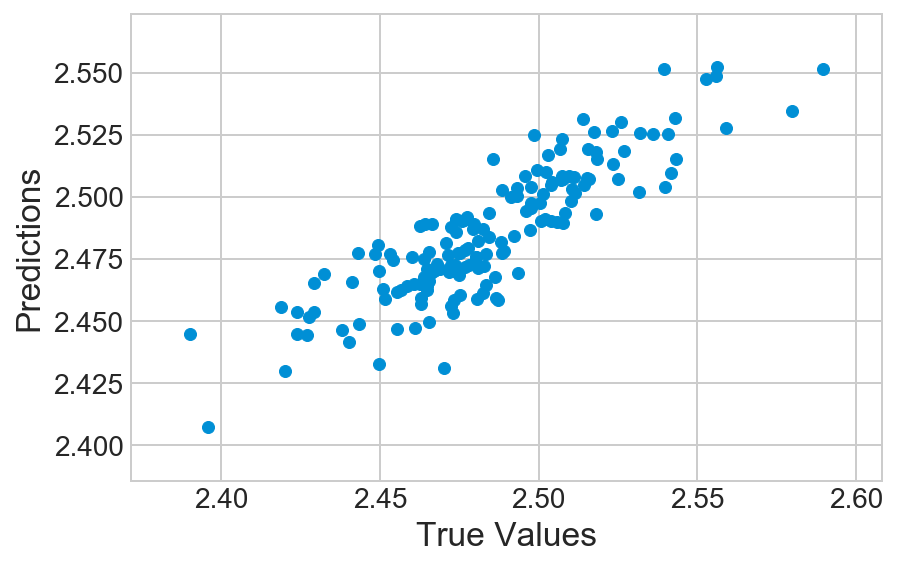

In [343]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lm = linear_model.LinearRegression(normalize=True)

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

lm_scores = cross_val_score(model, X_test, y_test, cv=10)
print("Average CV score",np.mean(lm_scores))

print("Score:", model.score(X_test, y_test))

# calculate RMSE
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# examine the coefficients
print(lm.coef_)
print(lm.intercept_)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

#### Building lasso regression

In [344]:
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.001, normalize=True)
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)

print("Score: ",lassoreg.score(X_test, y_test))
print("RMSE : ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Score:  -0.0019059106702541406
RMSE :  0.033060401345240284


In [345]:
### Finding optimal alpha value
from sklearn.linear_model import LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)
y_pred =optimal_lasso.predict(X_test)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0012701820052077545


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [346]:
print("Best alpha: ",optimal_lasso.alpha_)
print("Score :", optimal_lasso.score(X_test, y_test))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Best alpha:  0.0012701820052077545
Score : 0.7220256529671648
RMSE:  0.017413938707162634


In [347]:
lasso_coefs = pd.DataFrame({'variable':X_test.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)


,variable,coef,abs_coef
0,OverallQual,0.015350,0.015350
4,BsmtQual,-0.002414,0.002414
5,BsmtFinType1,-0.001845,0.001845
12,GarageQual,0.001658,0.001658
13,GarageCond,0.001472,0.001472
10,KitchenQual,-0.001319,0.001319
8,HeatingQC,-0.001056,0.001056
11,GarageFinish,-0.000831,0.000831
14,SaleCondition,0.000675,0.000675
1,OverallCond,0.000490,0.000490


The best score for second model 0.769 is lower than first best model 0.75 .<br>
Therefore, second model (for question 2)is not considered as good model for prediction of Sale Price

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [348]:
# A: